# Quantum Energy Teleportation protocol for long distances
https://doi.org/10.1049/qtc2.12090

The circuit is a modified version of the article's one.

### Import packages

Import necessary packages to create and simulate the protocol

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator

## Model

### Create Circuit

In [ ]:
def qet(h,k):
   qc = QuantumCircuit(4,4, metadata={'h':h, 'k':k})
    
   #Prepare the ground state
   alpha = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))
    
   qc.ry(2*alpha,0)
   qc.cx(0,1)
   qc.h(2)
   qc.cx(2,3)

   qc.barrier()
   # Alice's projective measurement
   qc.h(0)

   qc.barrier()
   # Prepare state for teleportation
   qc.cx(1,2)
   qc.h(1)

   qc.barrier()
   # Condicional operation for state teleportation
   qc.cx(2,3)
   qc.cz(1,3)

   qc.barrier()
   # Energy extraction conditional operations on teleported state
   theta = np.arctan2(h*k,h**2+2*k**2)

   qc.cry(-theta,0,3)

   qc.x(0)
   qc.cry(theta,0,3)
   qc.x(0)

   qc.barrier()
   return qc

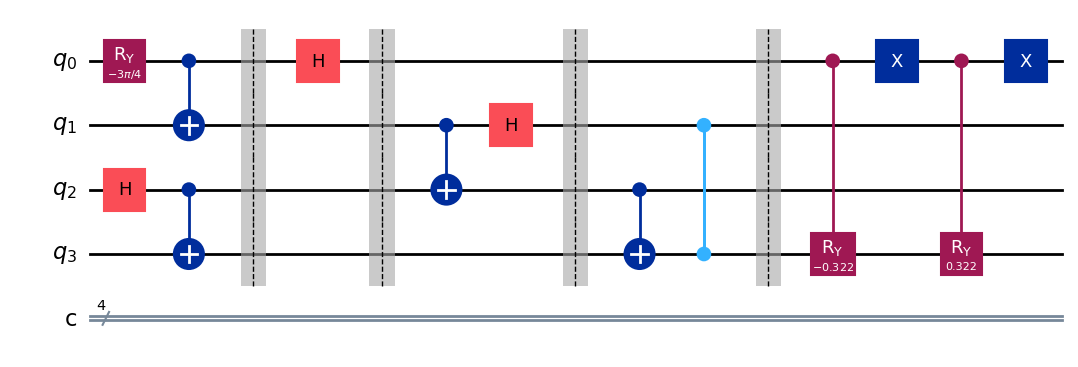

In [5]:
# Show circuit
qet(1,1).draw('mpl')

## Simulate circuit

In [ ]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1; k = 1;
n_shots = 100000

# Generate circuits
qc = qet(h, k)
qc.measure_all(add_bits=False)
qc_H = transpile(qc, simulator, optimization_level=3)

qc = qet(h, k)
qc.h(3)
qc.measure_all(add_bits=False)
qc_V = transpile(qc, simulator, optimization_level=3)

# Run job 
sim_H = simulator.run(qc_H, shots=n_shots)
sim_V = simulator.run(qc_V, shots=n_shots)


### Show results for circuit H

H_A = 0.7038667811865474 ± 0.003162261061961836
H_B = 0.2545267811865474 ± 0.0028198782661668213


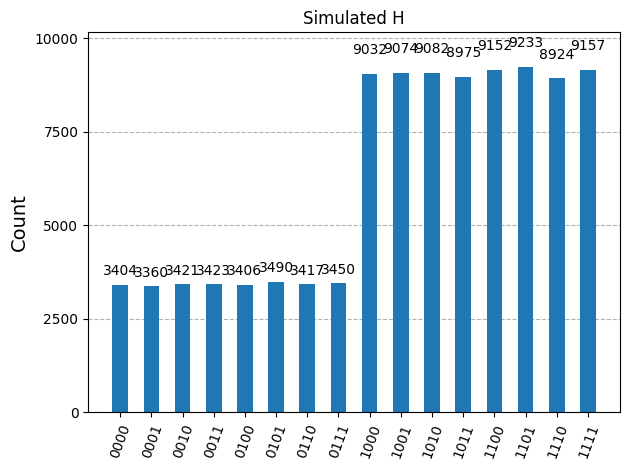

In [ ]:
# Extract results
result = sim_H.result()
counts = result.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[3])*count/n_shots
        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[3]))

# Show results
print(f"H_A = {ene_A} ± {np.std(error_A)/np.sqrt(n_shots)}")
print(f"H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
plot_histogram(counts, title="Simulated H")

### Show results for circuit V

V = -0.3743864376269049 ± 0.00283003540613894


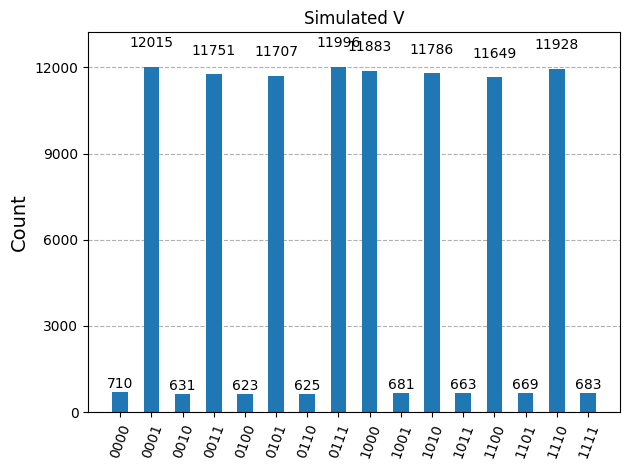

In [ ]:
# Extract results
result = sim_V.result()
counts = result.get_counts()

# Energy
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))

# Error array
error_V=[]

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[3])*count/n_shots
        for i in range(count):
            error_V.append(2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[3]))

# Show results
print(f"V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
plot_histogram(counts, title="Simulated V")

## Run circuit on hardware

### Import IBM packages

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, 
                                Batch, 
                                SamplerV2 as sampler, 
                                EstimatorV2 as estimator)
from qiskit.transpiler import preset_passmanagers
from qiskit.quantum_info import SparsePauliOp 

### Get backend

In [ ]:
# Log in IBM platform
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy()
print(backend.name)

ibm_marrakesh


### Run job with Sampler

In [ ]:
# Parameters
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]
n_shots = 3000

# Run job in Batch mode
with Batch(backend=backend):
    
    # initiate sampler and configure error mitigation
    sampler = sampler()
    options = sampler.options
    options.dynamical_decoupling.enable = True
    options.twirling.enable_gates = True
    options.twirling.enable_measure= True
    
    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits
        circuit_H = qet(h,k)
        circuit_H.measure_all(add_bits=False)
        transpiled_H = transpile(circuit_H, backend=backend, optimization_level=3)

        circuit_V = qet(h,k)
        circuit_V.h(3)
        circuit_V.measure_all(add_bits=False)
        transpiled_V = transpile(circuit_V, backend=backend, optimization_level=3)

        # Run job
        job_A = sampler.run([(transpiled_H),(transpiled_V)], shots=n_shots)
        job_A.update_tags([f'k={k},h={h}','error mitigated','sampler','LD',f'{n_shots}'])  # Add tags to job
        print(f"Sampler, ID = {job_A.job_id()}, h = {h}  k = {k}") 

c:\Users\julio\AppData\Local\Programs\Python\Python313\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:849: UserWarning: The backend ibm_marrakesh currently has a status of maintenance.
  warnings.warn(


Sampler H & V, ID = d41sfqkh4j8s73egtok0, h = 1  k = 1.5
Sampler H & V, ID = d41sfth8mjus73ccafeg, h = 1  k = 1
Sampler H & V, ID = d41sg0ch4j8s73egtoqg, h = 1  k = 0.5
Sampler H & V, ID = d41sg34h4j8s73egtoug, h = 0.5  k = 1
Sampler H & V, ID = d41sg5sh4j8s73egtp20, h = 1.5  k = 1


### Run job with Estimator

Run job with Estimator Primitive and error mitigation

In [ ]:
# Parameters h and k
variables = [(1,1.5), (1,1), (1,0.5), (0.5, 1), (1.5, 1)]

# Configure the transpiler
transpiler = preset_passmanagers.generate_preset_pass_manager(optimization_level=3, backend=backend)

#  Run job in Batch mode
with Batch(backend=backend):

    for variable in variables:
        h = variable[0]
        k = variable[1]
        observables = [SparsePauliOp('ZIII', h), SparsePauliOp('XIIX', 2*k)]

        # Generate circuit
        circuit_T = qet(h,k)
        circuit_T.h(0)
        transpiled_T = transpiler.run(circuit_T)
        
        # Run job
        transpiled_observables = [observable.apply_layout(transpiled_T.layout) for observable in observables]
        job_B = estimator(options={'resilience_level':2}).run([(transpiled_T, transpiled_observables)])  # transpiled_observables[0] or [1] to run separately
        job_B.update_tags([f'k={k},h={h}','error mitigated','estimator','LD']) # Add tags 
        print(f"Estimator, ID = {job_B.job_id()}, h = {h} k = {k}") 

Estimator H & V, ID = d41sgcglqprs73fkfs70, h = 1 k = 1.5
Estimator H & V, ID = d41sgd8lqprs73fkfs8g, h = 1 k = 1
Estimator H & V, ID = d41sgdolqprs73fkfs9g, h = 1 k = 0.5
Estimator H & V, ID = d41sgekh4j8s73egtpcg, h = 0.5 k = 1
Estimator H & V, ID = d41sgf0lqprs73fkfsbg, h = 1.5 k = 1


### Results

In [ ]:
# Extract results

# Sampler
jobS = service.job('') 
result = jobS.result()[0]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[0]
value_error = result.data.stds[0]

# parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energies
ene_B = (h**2)/(np.sqrt(h**2+k**2))
est_B = exp_value + ene_B

# Error array
error_B = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering
        ene_B += h*(-1)**int(bit_string[3])*count/n_shots 
        for i in range(count):
            error_B.append(h*(-1)**int(bit_string[3]))

# Show results
print(f"  Sampler H_B = {ene_B} ± {np.std(error_B)/np.sqrt(n_shots)}")
print(f"Estimator H_B = {est_B} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - H")

Sampler H_B = 0.5570754415067658 ± 0.024307193722572472
Estimator H_B = 0.4217364801537369 ± 0.03724424251663799


In [ ]:
# Extract results

# Sampler
jobS = service.job('')
result = jobS.result()[1]
counts = result.data.c.get_counts()
n_shots = result.data.c.num_shots

# Estimator
jobT = service.job('')
result = jobT.result()[0]
exp_value = result.data.evs[1]
value_error = result.data.stds[1]

# Parameters
metadata = result.metadata.get('circuit_metadata')
h = metadata.get('h')
k = metadata.get('k')

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))
est_V = exp_value + ene_V

# Error arrays
error_V = []

# Sum energy and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]  # Invert bits ordering  
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[3])*count/n_shots 
        for i in range(count):
            error_V.append(2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[3]))

# Print results
print(f"  Sampler V = {ene_V} ± {np.std(error_V)/np.sqrt(n_shots)}")
print(f"Estimator V = {est_V} ± {value_error}")
plot_histogram(counts, title=f"{jobS.backend().name} - V")

Sampler V = -0.2532662742162084 ± 0.0267278852858181
Estimator V = -0.3891752523505225 ± 0.004026631731575864


### Show Transpiled circuit (see qubit mapping)

In [ ]:
job = service.job('')
pubs = job.inputs['pubs'] 
circuits = [pub[0] for pub in pubs]
circuits[0].draw('mpl')